#StyleGAN2 Manipulation
#### Inference, Truncation, Interpolation, Mixing, and Projection

This notebook covers manipulating a StyleGAN2 model to produce images and videos. It was made by [Derrick Schultz](https://twitter.com/dvsch) and [Lia Coleman](https://twitter.com/Lialialiacole) for their StyleGAN2 Deep Dive course.

Parts of this notebook contain ideas and code from [Mikael Christensen](https://colab.research.google.com/drive/1ShgW6wohEFQtqs_znMna3dzrcVoABKIH) and [Dan Shiffman](https://www.youtube.com/watch?v=vEetoBuHj8g).

# Setup: Download the StyleGAN2 repo 




This will install all the necessary libraries to use the StyleGAN2 repo. Press the play button or `shift+return` to run each cell.

Only run the next cell once per session.


In [ ]:
%tensorflow_version 1.x

# Derrick's repo (even if you trained with skyflynil this will work!)
!git clone https://github.com/dvschultz/stylegan2 #use this fork to get interpolation functions
!pip install opensimplex # needed for noise interpolation
%cd stylegan2

Cloning into 'stylegan2'...
remote: Enumerating objects: 552, done.
remote: Total 552 (delta 0), reused 0 (delta 0), pack-reused 552
Receiving objects: 100% (552/552), 22.47 MiB | 12.55 MiB/s, done.
Resolving deltas: 100% (285/285), done.
/content/stylegan2/stylegan2


To make demoing easier, we can also add some functions to show images in Colab. Run the next cell to enable that code.

Unfortunately you can’t currently play video inside Colab, so you’ll have to download the videos to view them.

In [ ]:
from IPython.display import Image, display

### Download your trained model from Google Drive
Input the google id of your trained .pkl file. 
The -O option here is to specify the output file name and location.

In [ ]:
# Replace this id with the google id of YOUR trained .pkl file. The id here is for FFHQ.

!gdown https://drive.google.com/uc?id=107RuA3-uEwmonHL6-XnCU8YY9c6CQX-r

Downloading...
From: https://drive.google.com/uc?id=107RuA3-uEwmonHL6-XnCU8YY9c6CQX-r
To: /content/stylegan2/stylegan2/network-snapshot-010570.pkl
382MB [00:02, 165MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Inference 
Also known as "Evaluation" or "Testing" the model.
The following command will generate 50 sample images from the model.

##Options
`--network`

Make sure the `--network` argument points to your .pkl file. (My preferred method is to right click on the file in the Files pane to your left and choose `Copy Path`, then paste that into the argument after the `=` sign).

`--seeds`

This allows you to choose random seeds from the model. Remember that our input to StyleGAN is a 512-dimensional array. These seeds will generate those 512 values. Each seed will generate a different, random array. The same seed value will also always generate the same random array, so we can later use it for other purposes like interpolation.

`--truncation-psi`

Truncation is a special argument of StyleGAN. Essentially values that are closer to 0 will be more real than numbers further away from 0. I generally recommend a value between `0.5` and `1.0`. `0.5` will give you pretty "realistic" results, while `1.0` is likely to give you "weirder" results. Truncation is looked at more closely in the next section.

In [ ]:
!python run_generator.py generate-images --network=/content/stylegan2/network-snapshot-011062.pkl --seeds=1-200 --truncation-psi=0.7

Local submit - run_dir: results/00004-generate-images
dnnlib: Running run_generator.generate_images() on localhost...
Loading networks from "/content/stylegan2/network-snapshot-011062.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Generating image for seed 1 (1/200) ...
Generating image for seed 2 (2/200) ...
Generating image for seed 3 (3/200) ...
Generating image for seed 4 (4/200) ...
Generating image for seed 5 (5/200) ...
Generating image for seed 6 (6/200) ...
Generating image for seed 7 (7/200) ...
Generating image for seed 8 (8/200) ...
Generating image for seed 9 (9/200) ...
Generating image for seed 10 (10/200) ...
Generating image for seed 11 (11/200) ...
Generating image for seed 12 (12/200) ...
Generating image for seed 13 (13/200) ...
Generating image for seed 14 (14/200) ...
Generating image for seed 15 (15/200) ...
Generating image for seed 16 (16

Let’s look st a handful of images. 

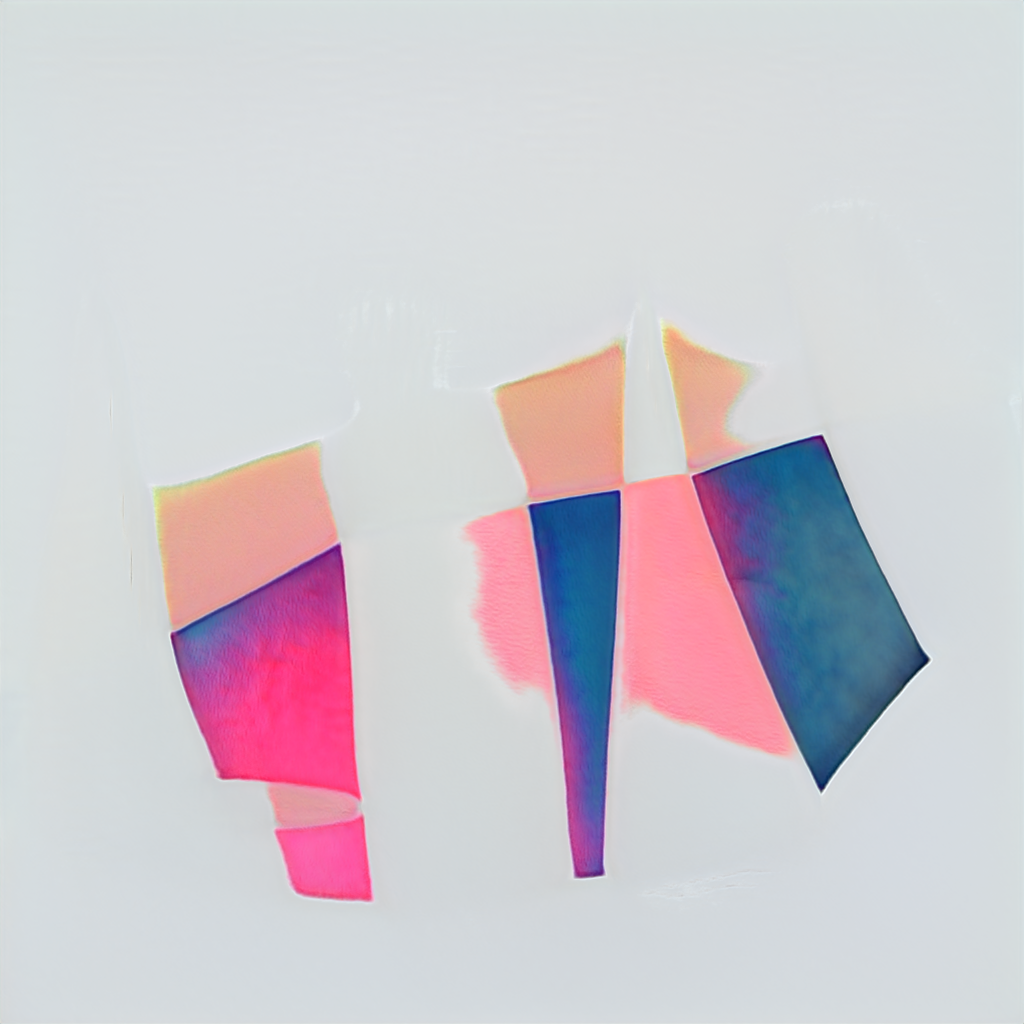

In [ ]:
listOfImageNames = ['/content/stylegan2/results/00000-generate-images/seed0018.png',
                    ]

for imageName in listOfImageNames:
    display(Image(filename=imageName, width=400))

Let’s zip the generated files and download them.

In [ ]:
!zip -r generated-trunc0.7.zip /content/stylegan2/results/00001-generate-images

  adding: content/stylegan2/results/00001-generate-images/ (stored 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0043.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0040.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/run.txt (deflated 32%)
  adding: content/stylegan2/results/00001-generate-images/seed0045.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/_finished.txt (stored 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0050.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0022.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0039.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0018.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0030.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/submit_config.txt (deflate

##Near neighbors
**Added by popular demand**

Let’s say you have a seed you like, but want to see other images like it to see if there’s something better. Now you can with the `near-neighbor` argument.

### Options
`--network`, `--seeds`, and `--truncation_psi` work the same as above.

`--diameter`: this sets how far away from the seed you want to generate images. `.0000001` is really close, `.5` is reallly far.

`--num_samples`: how many samples you want to produce

`--save_vector`: this will save the vector as a file in the .npy format. You can then use this for interpolation (not super well supported right now, but can be used manually—see the Projection code for an example of reading a .npy file and interpolating it).




In [ ]:
!python run_generator.py generate-neighbors --network=/content/network.pkl --seeds=10 --truncation-psi=0.5 --num_samples=10 --diameter=.000000005 --save_vector

# Truncation
Truncation, well, truncates the latent space. This can have a subtle or dramatic affect on your images depending on the value you use. Most people choose between 0.5 and 1.0, but technically its infinite. 

Below you can take one seed and look at the changes to it across any truncation amount. -1 to 1 will be pretty realistic images, but the further out you get the weirder it gets.

###Options 
`--network`: Again, point this to your .pkl file.

`--seed`: Pass this only one seed. Pick a favorite from your generated images.

`--start`: Starting truncation value.

`--stop`: Stopping truncation value. This should be larger than the start value. (Will probably break if its not).

`--increment`: How much each frame should increment the truncation value. Make this really small if you want a long, slow interpolation. (stop-start/increment=total frames)

In [ ]:
!python run_generator.py truncation-traversal --network=/content/stylegan2/network-snapshot-012772.pkl --seed=200 --start=-2.0 --stop=2.0 --increment=0.01

Local submit - run_dir: results/00007-truncation-traversal
dnnlib: Running run_generator.truncation_traversal() on localhost...
Loading networks from "/content/stylegan2/network-snapshot-012772.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Generating truncation -2.00
Generating truncation -1.99
Generating truncation -1.98
Generating truncation -1.97
Generating truncation -1.96
Generating truncation -1.95
Generating truncation -1.94
Generating truncation -1.93
Generating truncation -1.92
Generating truncation -1.91
Generating truncation -1.90
Generating truncation -1.89
Generating truncation -1.88
Generating truncation -1.87
Generating truncation -1.86
Generating truncation -1.85
Generating truncation -1.84
Generating truncation -1.83
Generating truncation -1.82
Generating truncation -1.81
Generating truncation -1.80
Generating truncation -1.79
Generating truncat

In [ ]:
listOfImageNames = ['/content/stylegan2/results/00002-truncation-traversal/frame00001.png',
                    '/content/stylegan2/results/00002-truncation-traversal/frame00011.png',
                    '/content/stylegan2/results/00002-truncation-traversal/frame00021.png',
                    '/content/stylegan2/results/00002-truncation-traversal/frame00031.png',
                    '/content/stylegan2/results/00002-truncation-traversal/frame00040.png',]

for imageName in listOfImageNames:
    display(Image(filename=imageName, width=400))

Let’s make all these frames into a video using ffmpeg. Make sure the path to your results folder is correct and give the mp4 an unique name.


In [ ]:
!ffmpeg -r 24 -i /content/stylegan2/results/00006-truncation-traversal/frame%05d.png -vcodec libx264 -pix_fmt yuv420p West.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

You can download the video in the Files panel to the left.

#Interpolation
Interpolation is the process of generating very small changes to a vector in order to make it appear animated from frame to frame.

We’ll look at two different example of interpolation: a linear interpolation and a random noise loop.

Both methods require the following options:

`--network`

`--walk-type`: Walk type defines the type of interpolation you want. In some cases it can also specify whether you want the z space or the w space.

`--frames`: How many frames you want to produce. Use this to manage the length of your video.

`--truncation-psi`


## Linear Interpolation

Linear interpolation generate a linear path from one seed to another. The makers of StyleGAN say that doing this in the w space produces the best disentangled interpolations. But let’s start by looking at it in z space.

`--seeds`: Use images you generated to control the interpolation points. If your first and last seed are the same this will produce a loop (nice for Instagram and gifs!)

In [ ]:
!python run_generator.py generate-latent-walk --network=/content/stylegan2/network-snapshot-010546.pkl --walk-type='line-z' --seeds=1,25,50,75,100,75,50,25,1 --frames 1000 --truncation-psi=0.7

Local submit - run_dir: results/00003-generate-latent-walk
dnnlib: Running run_generator.generate_latent_walk() on localhost...
Loading networks from "/content/network.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
not enough values to generate walk
Generating image for step 0/104 ...
Generating image for step 1/104 ...
Generating image for step 2/104 ...
Generating image for step 3/104 ...
Generating image for step 4/104 ...
Generating image for step 5/104 ...
Generating image for step 6/104 ...
Generating image for step 7/104 ...
Generating image for step 8/104 ...
Generating image for step 9/104 ...
Generating image for step 10/104 ...
Generating image for step 11/104 ...
Generating image for step 12/104 ...
Generating image for step 13/104 ...
Generating image for step 14/104 ...
Generating image for step 15/104 ...
Generating image for step 16/104 ...
Genera

Rather than try to look at these images in Colab let’s skip immediately to producing a video.

In [ ]:
!ffmpeg -r 24 -i ./results/00003-generate-latent-walk/frame%05d.png -vcodec libx264 -pix_fmt yuv420p line-z-walk.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

Download this video and look at it on your local computer. Controlling the speed depends on how many seeds you feed it and how many frames you want.



---
Next let’s look at linear interpolation in w space. To do this we set `--walk-type` to `line-w`.

I recommend using the exact same seeds so you see the difference. It’s often very subtle but it is different.


In [ ]:
!python run_generator.py generate-latent-walk --network=/content/network.pkl --walk-type='line-w' --seeds=58,10,32,63,44,24,70,16,47,58 --frames 100 --truncation-psi=0.5

Local submit - run_dir: results/00002-generate-latent-walk
dnnlib: Running run_generator.generate_latent_walk() on localhost...
Loading networks from "/content/network.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Generating image for step 0/108 ...
Generating image for step 1/108 ...
Generating image for step 2/108 ...
Generating image for step 3/108 ...
Generating image for step 4/108 ...
Generating image for step 5/108 ...
Generating image for step 6/108 ...
Generating image for step 7/108 ...
Generating image for step 8/108 ...
Generating image for step 9/108 ...
Generating image for step 10/108 ...
Generating image for step 11/108 ...
Generating image for step 12/108 ...
Generating image for step 13/108 ...
Generating image for step 14/108 ...
Generating image for step 15/108 ...
Generating image for step 16/108 ...
Generating image for step 17/108 ...
Gene

Same as before, let’s make a video and download it. 

Sometimes it is helpful to look at the individual frames between z and w space to see where they differ. Use the `zip` command (see above) to zip your files and download them.

In [ ]:
!ffmpeg -r 24 -i ./results/00002-generate-latent-walk/frame%05d.png -vcodec libx264 -pix_fmt yuv420p line-w-walk.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

## Noise Loop Interpolation

If you want to just make a random but fun interpolation of your model the noise loop is the way to go. It creates a random path thru the z space to show you a diverse set of images.

Seeds aren’t used here but you do need to set one for 🌟reasons🌟. Just leave it at zero but know that changing this value won’t do much.

`--diameter`: This controls how "wide" the loop is. Make it smaller to show a less diverse range of samples. Make it larger to cover a lot of samples. This plus `--frames` can help determine how fast the video feels.

`--start_seed`: this allows you to change your starting place in the z space. Note: this value has nothing to do with the seeds you use to generate images. It just allows you to randomize your start point (and if you want to return to it you can use the same seed multiple times).

In [73]:
!python run_generator.py generate-latent-walk --network=/content/stylegan2/network-snapshot-011062.pkl --walk-type='noiseloop' --frames 1000 --seeds=0 --truncation-psi=0.9 --diameter=1.5 --start_seed=10

Local submit - run_dir: results/00001-generate-latent-walk
dnnlib: Running run_generator.generate_latent_walk() on localhost...
Loading networks from "/content/stylegan2/network-snapshot-011062.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Generating image for step 0/1000 ...
Generating image for step 1/1000 ...
Generating image for step 2/1000 ...
Generating image for step 3/1000 ...
Generating image for step 4/1000 ...
Generating image for step 5/1000 ...
Generating image for step 6/1000 ...
Generating image for step 7/1000 ...
Generating image for step 8/1000 ...
Generating image for step 9/1000 ...
Generating image for step 10/1000 ...
Generating image for step 11/1000 ...
Generating image for step 12/1000 ...
Generating image for step 13/1000 ...
Generating image for step 14/1000 ...
Generating image for step 15/1000 ...
Generating image for step 16/1000 ..

Let’s download the video.

In [74]:
!ffmpeg -r 24 -i /content/stylegan2/stylegan2/results/00001-generate-latent-walk/frame%05d.png -vcodec libx264 -pix_fmt yuv420p street.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

# Mixing Seeds

Since seeds are just points in a vector space, we can do math things to them, like adding them together. You could do this thru linear interpolation and using the middle frame, but if you want to visualize a number of options here’s a simple script to do it. This takes a number of seeds to produce a grid showing what happens when you add the row and column together (this will make more sense after running it).

In [ ]:
!python run_generator.py style-mixing-example --network=/content/network.pkl --row-seeds=85,100,75,458,1500 --col-seeds=55,821,1789,293 --truncation-psi=0.5

Local submit - run_dir: results/00003-style-mixing-example
dnnlib: Running run_generator.style_mixing_example() on localhost...
Loading networks from "/content/network.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Generating W vectors...
Generating images...
Generating style-mixed images...
Saving images...
Saving image grid...
dnnlib: Finished run_generator.style_mixing_example() in 47s.


Let’s look at the `grid.png` file. Note this file is huge so it might be better to just download it.

In [ ]:
#Image('/content/stylegan2/results/00006-style-mixing-example/grid.png', width=1000)
# Don't do this! it will restart your runtime :( 
# Download the file instead.

For this one I definitely recommend zipping up the files and downloading them.

In [ ]:
!zip -r mixing-example.zip 

#Projection
Projection is the process of taking an image from outside the model and finding it’s nearest representation inside the model.

For projection, we’re gonna do something a little different in this notebook and load the code directly into Colab. Don’t worry if this looks scary—there’s only two things you want to edit in the code for any projection.

First, let’s download the ffhq pkl file—it’s a little more fun to see weird faces in the model.

In [ ]:
!gdown --id 1UlDmJVLLnBD9SnLSMXeiZRO6g-OMQCA_ -O /content/my_network.pkl

Downloading...
From: https://drive.google.com/uc?id=1UlDmJVLLnBD9SnLSMXeiZRO6g-OMQCA_
To: /content/ffhq.pkl
382MB [00:05, 72.3MB/s]


We also need to download a pretrained pkl file. This allows us to calculate how different our projection image is from the image in the model.

In [ ]:
!mkdir pkl
!gdown --id 1gbxwfHNOaGjGsLNTmmSrNA85X2VWHHOq -O /content/stylegan2/pkl/vgg16_zhang_perceptual.pkl

Downloading...
From: https://drive.google.com/uc?id=1gbxwfHNOaGjGsLNTmmSrNA85X2VWHHOq
To: /content/stylegan2/pkl/vgg16_zhang_perceptual.pkl
58.9MB [00:00, 76.8MB/s]


Next, all the code we need.

In [ ]:
network_pkl = "/content/network.pkl"

import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

import pretrained_networks

# Convert uploaded images to TFRecords
import dataset_tool

# Run the projector
import training.dataset
import training.misc
import projector
import os 

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

def interpolate(zs, steps,type='linear'):
  out = []
  for i in range(len(zs)-1):
    c = zs[i+1]-zs[i]

    for index in range(steps):
      fraction = index/float(steps) # t/d
      
      # translated from: https://github.com/danro/jquery-easing/blob/master/jquery.easing.js
      # see https://easings.net/ for examples
      if type == 'linear':
        out.append( c * fraction + zs[i] ) # c*(t/d)+b
      elif type == 'easeInSine':
        out.append( -c * np.cos(fraction * (np.pi/2)) + c + zs[i] ) # -c * Math.cos(t/d * (Math.PI/2)) + c + b
      elif type == 'easeOutSine':
        out.append( c * np.sin(fraction * (np.pi/2)) + zs[i]) # c * Math.sin(t/d * (Math.PI/2)) + b
      elif type == 'easeInOutSine':
        out.append(-c/2 * (np.cos(np.pi*fraction) - 1.0) + zs[i]) # -c/2 * (Math.cos(Math.PI*t/d) - 1) + b;
      elif type == 'easeInQuad':
        out.append(c * fraction * fraction + zs[i]) # c*(t/=d)*t + b;
      elif type == 'easeOutQuad':
       out.append(-c * fraction * (fraction-2) + zs[i]) # -c *(t/=d)*(t-2) + b;
      # elif type == 'easeInOutQuad':
      #   if(fraction/2 < 1):
      #     out.append( ((c/2)*fraction*fraction) + zs[i]) #if ((t/=d/2) < 1) return c/2*t*t + b;
      #   else:
		  #     out.append( (-c/2) * ((index-=1)*(index-2) - 1) + zs[i]; #return -c/2 * ((--t)*(t-2) - 1) + b;
      else: 
        out.append( c * fraction + zs[i] ) # c*(t/d)+b
  return out

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location + ('%05d.png' % (idx))
    img.save(file)

def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in enumerate(dlatents):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs  

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

Loading networks from "/content/micro-ct02-network.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


Next, we need to make some folders so we can upload the image for projection. Only run this cell once per session.

In [ ]:
!mkdir projection
!mkdir projection/imgs
!mkdir projection/out

# Now upload a single image to 'stylegan2/projection/imgs' (use the Files side panel). Image should be color PNG, with a size of 1024x1024.

In [ ]:
!rm projection/records/*.*
!rm projection/out/*.*

In [ ]:
!rm /content/stylegan2/projection/out/*.*

Now upload a single image to stylegan2/projection/imgs (use the Files side panel). Image should be color PNG, with a size of 1024x1024.

Things you might want to edit in here:

`file_name`: I recommend saving this to be something readable in case you want to do interpolations with it. Change it every time you switch projection samples.

`proj.num_steps`: this is the number of iterations you want the model to run thru. Higher numbers will increase accuracy but also take longer to produce.

In [ ]:
# Convert uploaded images to TFRecords
dataset_tool.create_from_images("./projection/records/", "./projection/imgs/", True)

!rm projection/out/*.*

def project_image_run(proj, targets, png_prefix, num_snapshots):
    snapshot_steps = set(proj.num_steps - np.linspace(0, proj.num_steps, num_snapshots, endpoint=False, dtype=int))
    training.misc.save_image_grid(targets, png_prefix + 'target.png', drange=[-1,1])
    proj.start(targets)
    while proj.get_cur_step() < proj.num_steps:
        print('\r%d / %d ... ' % (proj.get_cur_step(), proj.num_steps), end='', flush=True)
        proj.step()
        if proj.get_cur_step() in snapshot_steps:
            training.misc.save_image_grid(proj.get_images(), png_prefix + 'step%04d.png' % proj.get_cur_step(), drange=[-1,1])
    print('\r%-30s\r' % '', end='', flush=True)
    type(proj.get_noises())
    #if you want to do interpolations, name the file below something memorable
    file_name = 'mug'
    np.save(T('./projection/'+file_name+'.npy'), proj.get_dlatents())

def project_real_images(dataset_name, data_dir, num_images, num_snapshots):
    proj = projector.Projector()
    proj.set_network(Gs)
    #num_steps = how many iterations; larger = ~more accurate but longer run times 
    proj.num_steps=300

    print('Loading images from "%s"...' % dataset_name)
    dataset_obj = training.dataset.load_dataset(data_dir=data_dir, tfrecord_dir=dataset_name, max_label_size=0, verbose=True, repeat=False, shuffle_mb=0)
    print(dataset_obj.shape, Gs.output_shape[1:])
    assert dataset_obj.shape == Gs.output_shape[1:]

    for image_idx in range(num_images):
        print('Projecting image %d/%d ...' % (image_idx, num_images))
        images, _labels = dataset_obj.get_minibatch_np(1)
        images = training.misc.adjust_dynamic_range(images, [0, 255], [-1, 1])
        project_image_run(proj, targets=images, png_prefix=dnnlib.make_run_dir_path('projection/out/image%04d-' % image_idx), num_snapshots=num_snapshots)

project_real_images("records","./projection",1,100)

  0%|          | 0/1 [00:00<?, ?it/s]

Loading images from "./projection/imgs/"


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


rm: cannot remove 'projection/out/*.*': No such file or directory
Projector: Finding W midpoint and stddev using 100 samples...
Projector: std = 10.0564
Projector: Setting up noise inputs...
Projector: G_synthesis/noise0 <tf.Variable 'G_synthesis_2/noise0:0' shape=(1, 1, 4, 4) dtype=float32_ref>
Projector: G_synthesis/noise1 <tf.Variable 'G_synthesis_2/noise1:0' shape=(1, 1, 8, 8) dtype=float32_ref>
Projector: G_synthesis/noise2 <tf.Variable 'G_synthesis_2/noise2:0' shape=(1, 1, 8, 8) dtype=float32_ref>
Projector: G_synthesis/noise3 <tf.Variable 'G_synthesis_2/noise3:0' shape=(1, 1, 16, 16) dtype=float32_ref>
Projector: G_synthesis/noise4 <tf.Variable 'G_synthesis_2/noise4:0' shape=(1, 1, 16, 16) dtype=float32_ref>
Projector: G_synthesis/noise5 <tf.Variable 'G_synthesis_2/noise5:0' shape=(1, 1, 32, 32) dtype=float32_ref>
Projector: G_synthesis/noise6 <tf.Variable 'G_synthesis_2/noise6:0' shape=(1, 1, 32, 32) dtype=float32_ref>
Projector: G_synthesis/noise7 <tf.Variable 'G_synthesis_2/n

## Projection process video
Want to make one of those really cool projection videos? Run the code below.

In [ ]:
# Create video 
import glob

imgs = sorted(glob.glob("projection/out/*step*.png"))

target_imgs = sorted(glob.glob("projection/out/*target*.png"))
assert len(target_imgs) == 1, "More than one target found?"
target_img = imageio.imread(target_imgs[0])

movieName = "projection/movie.mp4"
with imageio.get_writer(movieName, mode='I') as writer:
    for filename in imgs:
        image = imageio.imread(filename)

        # Concatenate images with original target image
        w,h = image.shape[0:2]
        canvas = PIL.Image.new('RGBA', (w*2,h), 'white')
        canvas.paste(Image.fromarray(target_img), (0, 0))
        canvas.paste(Image.fromarray(image), (w, 0))

        writer.append_data(np.array(canvas))

### Make an interpolation!

Go back to the cell where you generate the projection and run it again. Make sure you use a different file name for `.npy` file.

If you generate a couple different projections, you can then interpolate between the different w values. 

(This is a little janky—if someone wants to write a cleaner function please let me or Lia know!)

In [ ]:
latent1 = np.load('/content/bladerunner.npy')
latent2 = np.load('/content/stylegan2/projection/c3po.npy')

imgs = generate_images_in_w_space(interpolate([latent1,latent2],144,'linear'),0.7)

!rm -rf interpolations
%mkdir interpolations
saveImgs(imgs,'./interpolations/')

Ok, we’re almost there. Let’s turn that interpolation into a video.

In [ ]:
!ffmpeg -r 24 -i ./interpolations/%05d.png -vcodec libx264 -pix_fmt yuv420p deckard-c3p0-v5.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena